# Classification Models for Student Outcome Prediction

## Objective
Build and compare supervised classification models to predict student final outcomes: **Pass**, **Fail**, **Distinction**, **Withdrawn** based on demographics and VLE engagement.

## CRISP-DM Stage
Modelling and Evaluation

## Models Implemented
- Logistic Regression (baseline, multiclass)
- Random Forest Classifier (multiclass)
- XGBoost Classifier (multiclass)
- Evaluation with Precision, Recall, F1-Score, Confusion Matrix

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import xgboost as xgb
import warnings
import re

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported successfully')
print('=' * 80)

All libraries imported successfully


## Section 1: Load Prepared Data

Load features and extract multiclass classification target (Distinction, Pass, Fail, Withdrawn) from final_result.

In [52]:
print('Loading prepared data...')
features = pd.read_pickle('../2_Outputs/features_prepared.pkl')
target = pd.read_pickle('../2_Outputs/target_prepared.pkl')
df_encoded = pd.read_pickle('../2_Outputs/df_encoded_full.pkl')

print(f'Features shape: {features.shape}')
print(f'Target shape: {target.shape}')

print('\n' + '=' * 80)
print('CREATING 4-CLASS CLASSIFICATION TARGET (Distinction, Pass, Fail, Withdrawn)')
print('=' * 80)

# Extract final_result as target
if 'final_result' in df_encoded.columns:
    target_class = df_encoded.loc[target.index, 'final_result']
else:
    raise ValueError('final_result column not found in df_encoded')

# Create 4-class target: Distinction (0), Pass (1), Fail (2), Withdrawn (3)
le = LabelEncoder()
class_names = np.array(['Distinction', 'Pass', 'Fail', 'Withdrawn'])

# Map target classes using LabelEncoder
le.fit(['Distinction', 'Pass', 'Fail', 'Withdrawn'])
target_class_encoded = le.transform(target_class)

print(f'\\nTarget classes: {list(class_names)}')
for idx, cls_name in enumerate(class_names):
    print(f'  {idx} = {cls_name}')
print(f'\nClassification target shape: {target_class_encoded.shape}')
print(f'\nClass distribution (full dataset):')
for cls_idx, cls_name in enumerate(class_names):
    count = (target_class_encoded == cls_idx).sum()
    pct = count / len(target_class_encoded) * 100
    print(f'  {cls_name}: {count} ({pct:.1f}%)')

Loading prepared data...
Features shape: (32593, 46)
Target shape: (32593,)

CREATING 4-CLASS CLASSIFICATION TARGET (Distinction, Pass, Fail, Withdrawn)
\nTarget classes: [np.str_('Distinction'), np.str_('Pass'), np.str_('Fail'), np.str_('Withdrawn')]
  0 = Distinction
  1 = Pass
  2 = Fail
  3 = Withdrawn

Classification target shape: (32593,)

Class distribution (full dataset):
  Distinction: 3024 (9.3%)
  Pass: 7052 (21.6%)
  Fail: 12361 (37.9%)
  Withdrawn: 10156 (31.2%)


## Section 2: Train-Test Split

Divide data with stratification to maintain class balance.

In [53]:
print('\n' + '=' * 80)
print('TRAIN-TEST SPLIT (STRATIFIED)')
print('=' * 80)

X_train, X_test, y_train, y_test = train_test_split(
    features, target_class_encoded,
    test_size=0.2,
    random_state=42,
    stratify=target_class_encoded
)

print(f'Training set size: {X_train.shape}')
print(f'Testing set size: {X_test.shape}')
print(f'\nClass distribution (training):')
for cls_idx in range(len(class_names)):
    count = (y_train == cls_idx).sum()
    pct = count / len(y_train) * 100
    print(f'  {class_names[cls_idx]}: {count} ({pct:.1f}%)')

print(f'\nClass distribution (testing):')
for cls_idx in range(len(class_names)):
    count = (y_test == cls_idx).sum()
    pct = count / len(y_test) * 100
    print(f'  {class_names[cls_idx]}: {count} ({pct:.1f}%)')


TRAIN-TEST SPLIT (STRATIFIED)
Training set size: (26074, 46)
Testing set size: (6519, 46)

Class distribution (training):
  Distinction: 2419 (9.3%)
  Pass: 5641 (21.6%)
  Fail: 9889 (37.9%)
  Withdrawn: 8125 (31.2%)

Class distribution (testing):
  Distinction: 605 (9.3%)
  Pass: 1411 (21.6%)
  Fail: 2472 (37.9%)
  Withdrawn: 2031 (31.2%)


## Section 3: Logistic Regression (Baseline)

Establish baseline with logistic regression.

In [54]:
print('\n' + '=' * 80)
print('LOGISTIC REGRESSION (BASELINE)')
print('=' * 80)

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

y_train_pred_log = log_reg.predict(X_train)
y_test_pred_log = log_reg.predict(X_test)

acc_log = accuracy_score(y_test, y_test_pred_log)
prec_log = precision_score(y_test, y_test_pred_log, average='weighted')
rec_log = recall_score(y_test, y_test_pred_log, average='weighted')
f1_log = f1_score(y_test, y_test_pred_log, average='weighted')
cv_scores_log = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='f1_weighted')

print('\\nLogistic Regression Results (weighted):')
print(f'  Accuracy:  {acc_log:.4f}')
print(f'  Precision: {prec_log:.4f}')
print(f'  Recall:    {rec_log:.4f}')
print(f'  F1-Score:  {f1_log:.4f}')
print(f'  5-Fold CV Mean F1 (weighted): {cv_scores_log.mean():.4f} (+/- {cv_scores_log.std():.4f})')

print('\nConfusion Matrix:')
cm_log = confusion_matrix(y_test, y_test_pred_log)
print(cm_log)
print('\nClassification Report:')
print(classification_report(y_test, y_test_pred_log, target_names=class_names))


LOGISTIC REGRESSION (BASELINE)
\nLogistic Regression Results (weighted):
  Accuracy:  0.6917
  Precision: 0.6501
  Recall:    0.6917
  F1-Score:  0.6413
  5-Fold CV Mean F1 (weighted): 0.6341 (+/- 0.0034)

Confusion Matrix:
[[  19    6  579    1]
 [   3  435  428  545]
 [  25   89 2346   12]
 [   0  289   33 1709]]

Classification Report:
              precision    recall  f1-score   support

 Distinction       0.40      0.03      0.06       605
        Pass       0.53      0.31      0.39      1411
        Fail       0.69      0.95      0.80      2472
   Withdrawn       0.75      0.84      0.80      2031

    accuracy                           0.69      6519
   macro avg       0.60      0.53      0.51      6519
weighted avg       0.65      0.69      0.64      6519



## Section 4: Random Forest Classifier

Implement ensemble classifier for non-linear patterns.

In [55]:
print('\n' + '=' * 80)
print('RANDOM FOREST CLASSIFIER')
print('=' * 80)

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

acc_rf = accuracy_score(y_test, y_test_pred_rf)
prec_rf = precision_score(y_test, y_test_pred_rf, average='weighted')
rec_rf = recall_score(y_test, y_test_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_test_pred_rf, average='weighted')
cv_scores_rf = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='f1_weighted')

print('\\nRandom Forest Results (weighted):')
print(f'  Accuracy:  {acc_rf:.4f}')
print(f'  Precision: {prec_rf:.4f}')
print(f'  Recall:    {rec_rf:.4f}')
print(f'  F1-Score:  {f1_rf:.4f}')
print(f'  5-Fold CV Mean F1 (weighted): {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})')

print('\nConfusion Matrix:')
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
print(cm_rf)


RANDOM FOREST CLASSIFIER
\nRandom Forest Results (weighted):
  Accuracy:  0.7061
  Precision: 0.6879
  Recall:    0.7061
  F1-Score:  0.6513
  5-Fold CV Mean F1 (weighted): 0.6541 (+/- 0.0056)

Confusion Matrix:
[[  28    2  575    0]
 [   0  407  418  586]
 [  14   44 2410    4]
 [   0  243   30 1758]]


## Section 5: XGBoost Classifier

Apply gradient boosting for classification.

In [56]:
print('\n' + '=' * 80)
print('XGBOOST CLASSIFIER')
print('=' * 80)

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective='multi:softmax',
    num_class=4
)

xgb_clf.fit(X_train, y_train, verbose=False)

y_train_pred_xgb = xgb_clf.predict(X_train)
y_test_pred_xgb = xgb_clf.predict(X_test)

acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
prec_xgb = precision_score(y_test, y_test_pred_xgb, average='weighted')
rec_xgb = recall_score(y_test, y_test_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_test_pred_xgb, average='weighted')
cv_scores_xgb = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='f1_weighted')

print('\\nXGBoost Results (weighted):')
print(f'  Accuracy:  {acc_xgb:.4f}')
print(f'  Precision: {prec_xgb:.4f}')
print(f'  Recall:    {rec_xgb:.4f}')
print(f'  F1-Score:  {f1_xgb:.4f}')
print(f'  5-Fold CV Mean F1 (weighted): {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std():.4f})')

print('\nConfusion Matrix:')
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
print(cm_xgb)


XGBOOST CLASSIFIER
\nXGBoost Results (weighted):
  Accuracy:  0.7150
  Precision: 0.7047
  Recall:    0.7150
  F1-Score:  0.6673
  5-Fold CV Mean F1 (weighted): 0.6652 (+/- 0.0041)

Confusion Matrix:
[[  49    1  555    0]
 [   1  456  391  563]
 [  16   56 2393    7]
 [   0  242   26 1763]]


## Section 5b: Hyperparameter Optimisation

Tune each classifier using cross-validated search on the training set, then re-evaluate on the test set.

In [57]:
print('\n' + '=' * 80)
print('HYPERPARAMETER OPTIMISATION')
print('=' * 80)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Logistic Regression tuning
log_param_grid = {
    'C': [0.1, 1, 10],
    'class_weight': [None, 'balanced'],
    'multi_class': ['multinomial']
}
log_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=2000),
    param_grid=log_param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1
)
log_search.fit(X_train, y_train)
log_reg = log_search.best_estimator_

print(f"Best Logistic Regression params: {log_search.best_params_}")

# Random Forest tuning
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1
)
rf_search.fit(X_train, y_train)
rf_clf = rf_search.best_estimator_

print(f"Best Random Forest params: {rf_search.best_params_}")

# XGBoost tuning (random search for speed)
xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb.XGBClassifier(
        random_state=42,
        n_jobs=-1,
        objective='multi:softmax',
        num_class=4
    ),
    param_distributions=xgb_param_dist,
    n_iter=10,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)
xgb_clf = xgb_search.best_estimator_

print(f"Best XGBoost params: {xgb_search.best_params_}")

# Re-evaluate using optimised models
print('\nRe-evaluating optimised models...')

y_train_pred_log = log_reg.predict(X_train)
y_test_pred_log = log_reg.predict(X_test)
acc_log = accuracy_score(y_test, y_test_pred_log)
prec_log = precision_score(y_test, y_test_pred_log, average='weighted')
rec_log = recall_score(y_test, y_test_pred_log, average='weighted')
f1_log = f1_score(y_test, y_test_pred_log, average='weighted')
cm_log = confusion_matrix(y_test, y_test_pred_log)


y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)
acc_rf = accuracy_score(y_test, y_test_pred_rf)
prec_rf = precision_score(y_test, y_test_pred_rf, average='weighted')
rec_rf = recall_score(y_test, y_test_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_test_pred_rf, average='weighted')
cm_rf = confusion_matrix(y_test, y_test_pred_rf)


y_train_pred_xgb = xgb_clf.predict(X_train)
y_test_pred_xgb = xgb_clf.predict(X_test)
acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
prec_xgb = precision_score(y_test, y_test_pred_xgb, average='weighted')
rec_xgb = recall_score(y_test, y_test_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_test_pred_xgb, average='weighted')
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

print('Optimisation complete.')


HYPERPARAMETER OPTIMISATION
Best Logistic Regression params: {'C': 0.1, 'class_weight': None, 'multi_class': 'multinomial'}
Best Random Forest params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best XGBoost params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1.0}

Re-evaluating optimised models...
Optimisation complete.


## Section 5d: SMOTE Resampling for Minority Classes

Apply SMOTE to training data only to balance class distribution, then retrain optimised models.

In [58]:
print('\n' + '=' * 80)
print('SMOTE RESAMPLING')
print('=' * 80)

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("Installing imbalanced-learn...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'imbalanced-learn', '-q'])
    from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data only
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f'Original training distribution:')
unique, counts = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f'  {class_names[cls]}: {cnt}')

print(f'\nAfter SMOTE:')
unique, counts = np.unique(y_train_smote, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f'  {class_names[cls]}: {cnt}')

# Retrain optimised models on SMOTE-resampled data
print(f'\nRetraining models on SMOTE-resampled data...')

log_reg.fit(X_train_smote, y_train_smote)
rf_clf.fit(X_train_smote, y_train_smote)
xgb_clf.fit(X_train_smote, y_train_smote, verbose=False)

# Get predictions from SMOTE-trained models
y_test_pred_log = log_reg.predict(X_test)
y_test_pred_rf = rf_clf.predict(X_test)
y_test_pred_xgb = xgb_clf.predict(X_test)

# Re-evaluate with SMOTE-trained models
acc_log = accuracy_score(y_test, y_test_pred_log)
prec_log = precision_score(y_test, y_test_pred_log, average='weighted')
rec_log = recall_score(y_test, y_test_pred_log, average='weighted')
f1_log = f1_score(y_test, y_test_pred_log, average='weighted')
cm_log = confusion_matrix(y_test, y_test_pred_log)

acc_rf = accuracy_score(y_test, y_test_pred_rf)
prec_rf = precision_score(y_test, y_test_pred_rf, average='weighted')
rec_rf = recall_score(y_test, y_test_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_test_pred_rf, average='weighted')
cm_rf = confusion_matrix(y_test, y_test_pred_rf)

acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
prec_xgb = precision_score(y_test, y_test_pred_xgb, average='weighted')
rec_xgb = recall_score(y_test, y_test_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_test_pred_xgb, average='weighted')
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

print('\nSMOTE resampling and model retraining complete.')


SMOTE RESAMPLING
Original training distribution:
  Distinction: 2419
  Pass: 5641
  Fail: 9889
  Withdrawn: 8125

After SMOTE:
  Distinction: 9889
  Pass: 9889
  Fail: 9889
  Withdrawn: 9889

Retraining models on SMOTE-resampled data...

SMOTE resampling and model retraining complete.


## Section 6: Model Comparison and Visualisation

Compare classification models with confusion matrices and ROC curves.


CLASSIFICATION MODEL COMPARISON

              Model  Accuracy  Precision   Recall  F1-Score
      Random Forest  0.689216   0.668814 0.689216  0.672703
            XGBoost  0.689523   0.663423 0.689523  0.667708
Logistic Regression  0.617119   0.633646 0.617119  0.623340


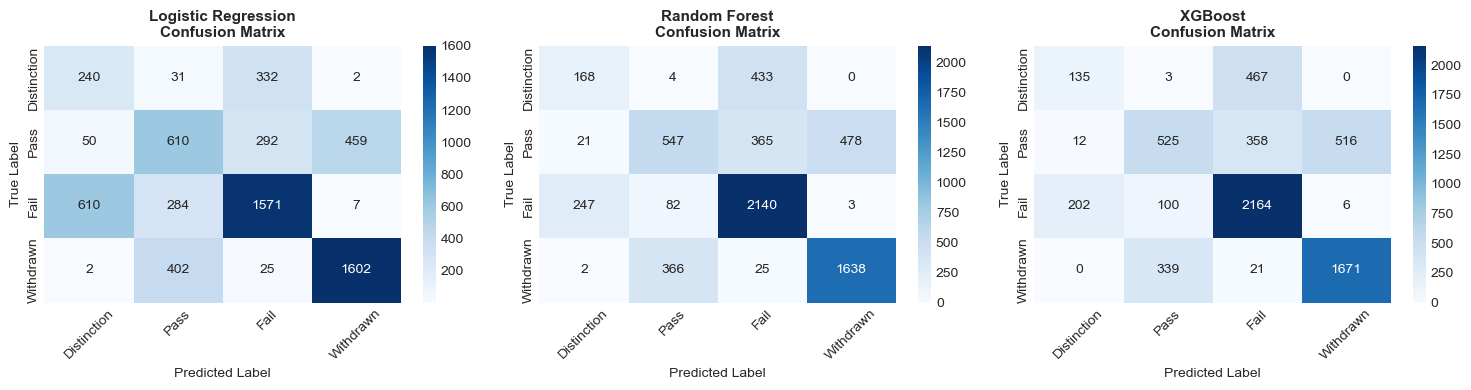

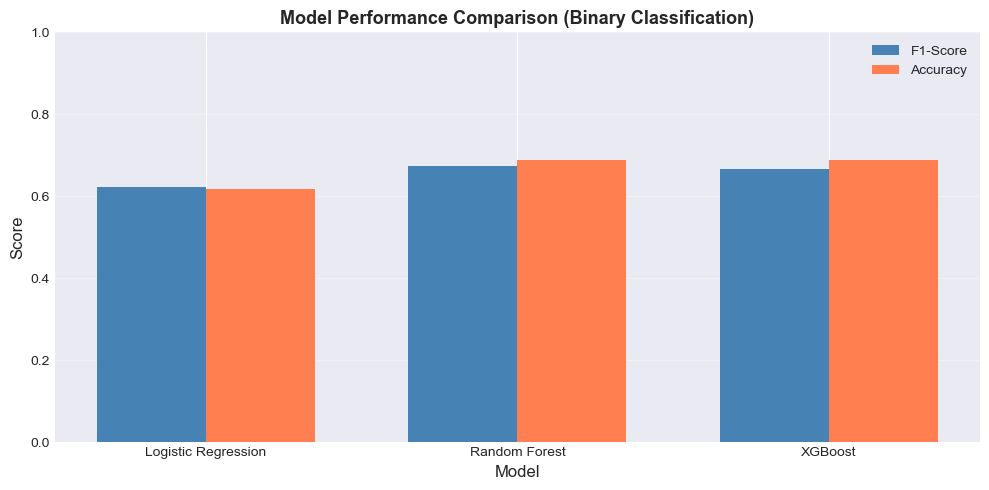


Best Model: Random Forest
F1-Score (weighted): 0.6727
Accuracy: 0.6892

Best model saved for final notebook


In [59]:
print('\n' + '=' * 80)
print('CLASSIFICATION MODEL COMPARISON')
print('=' * 80)

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [acc_log, acc_rf, acc_xgb],
    'Precision': [prec_log, prec_rf, prec_xgb],
    'Recall': [rec_log, rec_rf, rec_xgb],
    'F1-Score': [f1_log, f1_rf, f1_xgb]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
print('\n' + comparison_df.to_string(index=False))

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (cm, title, ax) in enumerate(zip(
    [cm_log, cm_rf, cm_xgb],
    ['Logistic Regression', 'Random Forest', 'XGBoost'],
    axes
)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f'{title}\nConfusion Matrix', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Per-class performance (optional for binary, but good for understanding)
fig, ax = plt.subplots(figsize=(10, 5))

models = ['Logistic Regression', 'Random Forest', 'XGBoost']
f1_scores = [f1_log, f1_rf, f1_xgb]
accs = [acc_log, acc_rf, acc_xgb]

x = np.arange(len(models))
width = 0.35

ax.bar(x - width/2, f1_scores, width, label='F1-Score', color='steelblue')
ax.bar(x + width/2, accs, width, label='Accuracy', color='coral')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison (Binary Classification)', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(alpha=0.3, axis='y')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print(f'\nBest Model: {comparison_df.iloc[0]["Model"]}')
print(f'F1-Score (weighted): {comparison_df.iloc[0]["F1-Score"]:.4f}')
print(f'Accuracy: {comparison_df.iloc[0]["Accuracy"]:.4f}')

# Save best model
best_model_name = comparison_df.iloc[0]['Model']
if 'Random Forest' in best_model_name:
    best_clf = rf_clf
elif 'XGBoost' in best_model_name:
    best_clf = xgb_clf
else:
    best_clf = log_reg

import pickle
pickle.dump(best_clf, open('../2_Outputs/best_classification_model.pkl', 'wb'))
print('\nBest model saved for final notebook')